# Regression Model Validation
Once we are able to work with data effectively and create models, we need a way to evaluate if these models are any good.  If the models are not performing well we will also need further details to make sure we can fix them properly.

## Residual Plot
A residual plot is essentially a graph of where error occurs in a model (residual is another way to say error in this case).  To draw a residual plot we use the model's prediction for the x axis and the residual for the y axis.  By doing this we can examine a model's prediction and how much error it had for that prediction.  If a model is working well it will typically have the following characteristics.

* symmetrically distributed
* small range on the y axis
* no clear patterns

There are a few thing things we can try to fix a poorly performing regression model: input data should be normally distributed (scalers), we might need more features (feature engineering), or a non linear model (polynomial).

In this example we have a good model, there is no shape to the residuals, the are centered around the line, and the range of y values is small (or is it, could a value of 1 ever be considered large?).

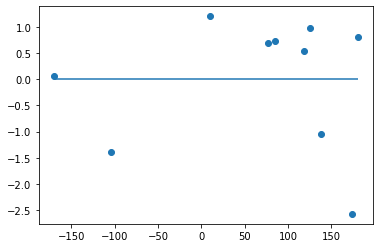

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve

X, y = make_regression(n_samples=10, n_features=1, noise=1)

regr = LinearRegression()
regr.fit(X, y)

preds = regr.predict(X)
# order is important!  actual - predictions
plt.scatter(preds, y-preds)
plt.hlines(y=0, xmin=preds.min(), xmax=preds.max())
plt.show()

In this example there is clearly a shape to the error, this indicates that the data is a curve of some sort and we are trying to fit a line through it.  Another strange shape that can occur are straight lines, this typically happens when those samples consist of sparse data, or linearly increasing discrete data, or there is a perfect linear relationship between input and output data.

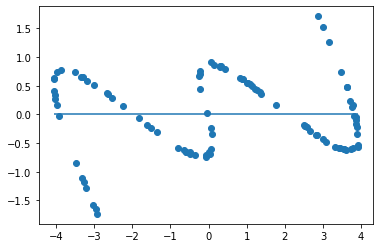

In [2]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve

X, y = make_s_curve()

regr = LinearRegression()
regr.fit(X, y)
preds = regr.predict(X)

plt.scatter(preds, y - preds)
plt.hlines(y=0, xmin=preds.min(), xmax=preds.max())
plt.show()

Sometimes only part of the residuals are large, this still indicates a problem that we can fix.  In the example below it looks like some predications are very close, but as the size of the prediction grows the residuals also grow.

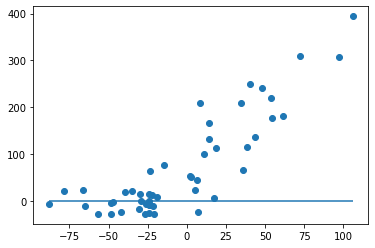

In [3]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve
import numpy as np

X, y = make_regression(n_samples=50, n_features=1, noise=20)

regr = LinearRegression()
regr.fit(X, y)

preds = regr.predict(X)
y = np.where(y > 0, y * 5, y)
plt.scatter(preds, y - preds)
plt.hlines(y=0, xmin=preds.min(), xmax=preds.max())
plt.show()

The last type of error we'll look at are outliers.  In this example there is only a single large residual.  In cases like this just examine your model and see if the outlier is causing any bad performance.  If the outlier is not affecting the model it is safe to leave in, if it causing the model to misbehave then it is safe to just remove the sample.

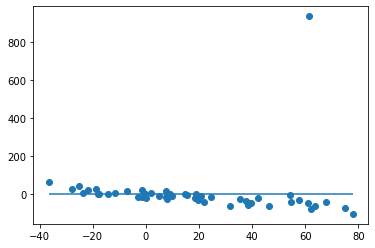

In [ ]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve

X, y = make_regression(n_samples=50, n_features=1, noise=20)
y[-1] = 999

regr = LinearRegression()
regr.fit(X, y)

preds = regr.predict(X)
plt.scatter(preds, y - preds)
plt.hlines(y=0, xmin=preds.min(), xmax=preds.max())
plt.show()

Generally one of the following solutions will helps us fix any issues found with a residual plot.

* normalizing features (typically input, but sometimes output as well)
* creating a more complex model (adding features, such as feature interactions)
* creating a polynomial model (perhaps the relationship is not linear)

# Metrics
The more robust our understanding of a model's performance is, the more likely we will be able to find and fix problems.  Examining the score and residual plot of a model is a good start, but we will often need to look at additional metrics as well (just as with the classification report).  In sklearn's metric namespace there are many tools we can use to further examine the error a model, here are a few common ones when dealing with regression problems.

* r2 - how well predictions match the ground truth (score returns this)
* MSE - mean squared error, as this value is squared larger residuals will affect MSE more
* MAE - mean absolute error, treats all error ranges the same
* MAPE - mean error as a percent, not implemented in sklearn but can be calculated easily enough (beware divide by 0)
     * mean(abs((truth - predictions) / truth)) * 100

In [13]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

X, y = make_regression(n_samples=50, n_features=1, noise=20)
model = LinearRegression()
model.fit(X, y)
pred = model.predict(X)

print(f'r2: {r2_score(y, pred)}')
print(f'MSE: {mean_squared_error(y, pred)}')
print(f'MAE: {mean_absolute_error(y, pred)}')

r2: 0.7519093200539206
MSE: 425.4171786754759
MAE: 15.560554634500713


# Bias Variance Dilemma
The error in a model can be broken down into different parts, bias and variance.  The bias in a model is what we have been thinking of as error up until now, how far off are predictions from ground truth.  The new way to think about error is variance, this is essentially how consistent the model is at making good predictions.  These two types of error are actually related, if we reduce bias we increase variance and vice versa, this is known as the bias variance dilemna.

Imagine your're playing basketball, whenever you shoot the ball you always miss but you always hit the exact same spot (high bias, low variance).  Now imagine most of your shots get in, but when you miss the shots go wild (low bias, high variance).  Or you could just make every shot (low bias, low variance).

## Detection
Detection of bias / variance is actually pretty straight forward, all we have to do is add an extra to call to score passing the training data instead of the testing data.  If your model scores high on training data this means it understood its training, if the testing score is high that means it works well on data that its never seen before.

* training score low, test score low - model is underfit
    * model is too simple, add features, tune model (or different model), try boosting ensemble
* training score high, test score low - model is overfit
    * model is too complex, remove features, tune model (or different model), try bagging ensemble
* training score high, test score high - model is working well
    * celebrate!
* low training score, high test score - typically not possible
    * despair!
    
We can still use our threshold of 0.75 to separate good and bad scores, but how far apart do the train and test scores need to be before we consider the model overfit?  Well they will never be equal, so anything within a few points is acceptable.  Any difference less than 10 I would consider a minor overfit, anything more a major overfit.

In [6]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X, y = make_regression(n_samples=100, n_features=1, noise=10, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y)

lr = LinearRegression()
lr.fit(X_train, y_train)

train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)
print(f'train: {train_score:.4f}')
print(f'test: {test_score:.4f}')

train: 0.9330
test: 0.8869


### Examples
If a model is not complex enough it cannot capture the shape of the data, if the model is too complex it has memorized the shape of the training data.

<img src="images\bias_variance.png" width=800/> </td>

# Workflow
There is not a strict blueprint for how to complete a machine learning problem, with varying data the workflow for each problem will be drastically different.  This general workflow can help, but shouldn't be strictly followed.  As the course progresses we will uncover more and transition from naive approaches to more robust.

<td> <img src="images\ml_workflow02.png" alt="Drawing" style="width:850px;"/> </td>

# OK
So know we know how to predict labels and continous data using different learning algorithms, we also explored better ways to score our estimators in order to find the best algorithm for our data.  Creating and training a model is only half of the work, we will need to analyze different metrics and visualizations to determine how best to improve the model.